# Read lagrangian trajectories and compute basic statistics

## Read data a get all pairs of particles

The data was generated from the fortran output of lagrangian trajectories "fort.1001" and converted into a netcdf file using the notebook "convert-data.ipynb"

In [1]:
import numpy as np
import xarray as xr
import sys
sys.path.append('../')
from xdispersion import RelativeDispersion

drifters = xr.open_dataset('./QGdaphne-E12e-8/fort.1001.np4000nt3000.nc')

npa = drifters.dims['tracer'] #number particles
print(npa)
print(npa*(npa-1)/2) #expected number of pairs

3395
5761315.0


/tmp/ipykernel_62816/3429143077.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  npa = drifters.dims['tracer'] #number particles


Now we initialize a `RelativeDispersion` class, with the `drifters` dataset and associated names for position and velocity. 

In [2]:
rd = RelativeDispersion(drifters, ragged=False, ID='tracer',
                        xpos='x', uvel='ux', time='time',
                        ypos='y', vvel='uy', coord='cartesian')

print(rd)

pairs = rd.get_all_pairs()
pairs


 RelativeDispersion class with:
   xpos: x 
   ypos: y 
   uvel: ux 
   vvel: uy 
   time: time 
  coord: cartesian
  delta:  0.049
maxtlen: -1



<xarray.Dataset> Size: 438MB
Dimensions:   (pair: 5761315, particle: 2)
Coordinates:
  * pair      (pair) int32 23MB 0 1 2 3 4 ... 5761311 5761312 5761313 5761314
  * particle  (particle) int32 8B 0 1
Data variables:
    tlen      (pair) float64 46MB 3e+03 3e+03 3e+03 3e+03 ... 3e+03 3e+03 3e+03
    stime     (pair) float64 46MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    r0        (pair) float64 46MB 0.3047 0.6908 0.4489 ... 0.6845 0.6117 0.3322
    pID       (pair, particle) int64 92MB 0 1 0 2 0 ... 3393 3392 3394 3393 3394
    xpos0     (pair, particle) float64 92MB ...
    ypos0     (pair, particle) float64 92MB ...

## Plot a histogram of initial separation distances

In [3]:
r0_min = pairs.r0.min().item()
r0_max = pairs.r0.max().item()
print(r0_min)
print(r0_max)

5.528109842236837e-05
0.9775524518831596


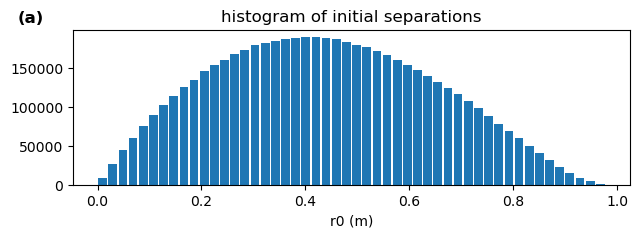

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6.5, 2.5), facecolor='w')

ax.hist(pairs.r0, bins=np.linspace(0, r0_max, 51), rwidth=0.86)
ax.set_xlabel('r0 (m)')
ax.set_title('histogram of initial separations')
ax.text(-0.1, 1.05, '(a)', transform=ax.transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Select pairs based on initial separation

In [5]:
origin_pairs = rd.get_original_pairs(pairs, r0=[0.005, 0.01])
# This is equivalent to:
# condition = np.logical_and(pairs.r0>=0.18, pairs.r0<=0.22)
# origin_pairs = pairs.where(condition, drop=True).astype(pairs.dtypes)

origin_pairs

<xarray.Dataset> Size: 138kB
Dimensions:   (pair: 1818, particle: 2)
Coordinates:
  * pair      (pair) int32 7kB 3025 9022 14113 17258 ... 5743989 5744594 5759498
  * particle  (particle) int32 8B 0 1
Data variables:
    tlen      (pair) float64 15kB 3e+03 3e+03 3e+03 3e+03 ... 3e+03 3e+03 3e+03
    stime     (pair) float64 15kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    r0        (pair) float64 15kB 0.006749 0.006215 ... 0.006429 0.006362
    pID       (pair, particle) int64 29kB 0 3026 2 2238 ... 3211 3327 3334 3348
    xpos0     (pair, particle) float64 29kB 0.238 0.2413 ... 0.3643 0.3655
    ypos0     (pair, particle) float64 29kB -0.0385 -0.03266 ... 0.07207 0.07833

Now we can plot the initial positions of original pairs. We can see that using pairs_filtered, we excude particles outside the tank's radius.

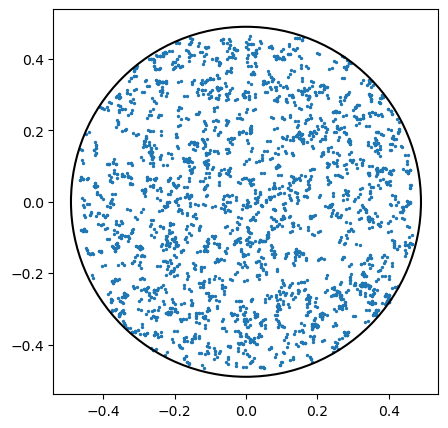

In [6]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(9,5), facecolor='w')
ax.scatter(origin_pairs.xpos0, origin_pairs.ypos0, s=2)
# Add a circle of radius 0.49 centered at (0, 0)
circle = patches.Circle((0, 0), 0.49, edgecolor='black', facecolor='none', lw=1.5)
ax.add_patch(circle)
ax.set_aspect('equal')
#ax.set_xlim([-90, -86])
#ax.set_ylim([27.5, 29.5])
#ax.format(abc='(a)', land=True, coast=True, reso='hi', landcolor='lightgray')

## Plot trajectories

Plot trajectories only for the selected origin_pairs.

/tmp/ipykernel_62816/3973523465.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', N+1)  # You can change colormap to 'viridis', 'plasma', etc.


Text(0.5, 1.0, 'trajectories of original pairs selected on initial separation')

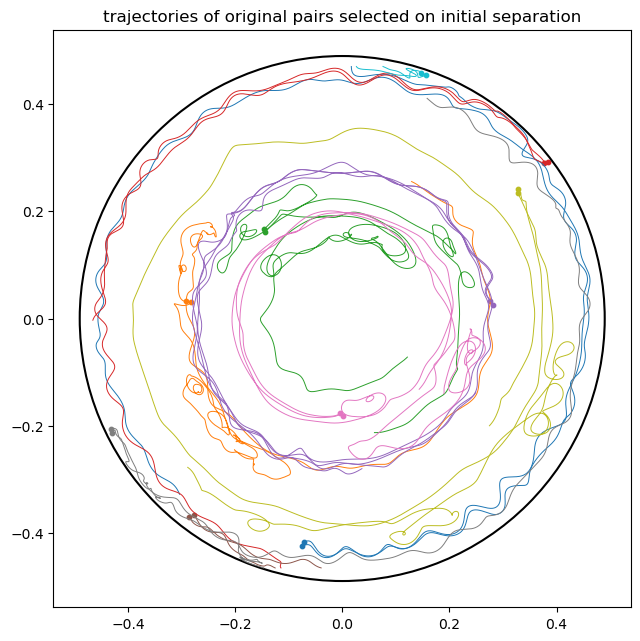

In [7]:
import matplotlib.cm as cm

xpos = rd.get_variable(origin_pairs, 'x')
ypos = rd.get_variable(origin_pairs, 'y')

# Total number of pairs
n_pairs = xpos.sizes['pair']

# Select N random pairs (e.g., 20), excluding pair 0
N = 10
pair_indices = np.random.choice(np.arange(1, n_pairs), size=N, replace=False)
cmap = cm.get_cmap('tab20', N+1)  # You can change colormap to 'viridis', 'plasma', etc.

fig, ax = plt.subplots(figsize=(13.5, 7.5), facecolor='w')
# Plot trajectories for selected pairs
for c,pairid in enumerate(pair_indices):
    #print(c)
    xpos_sel = xpos.isel(pair=pairid)
    ypos_sel = ypos.isel(pair=pairid)
    ax.plot(xpos_sel.T, ypos_sel.T, lw=0.7,color=cmap(c))

    # Add original positions
    x0 = origin_pairs.xpos0.isel(pair=pairid)
    y0 = origin_pairs.ypos0.isel(pair=pairid)
    ax.scatter(x0, y0, s=10, color=cmap(c))
# Add a circle of radius 0.49 centered at (0, 0)
circle = patches.Circle((0, 0), 0.49, edgecolor='black', facecolor='none', lw=1.5)
ax.add_patch(circle)
ax.set_aspect('equal')
#ax.set_xlim([-92, -83])
#ax.set_ylim([26, 30.5])
ax.set_title('trajectories of original pairs selected on initial separation')





## Plot relative dispersion

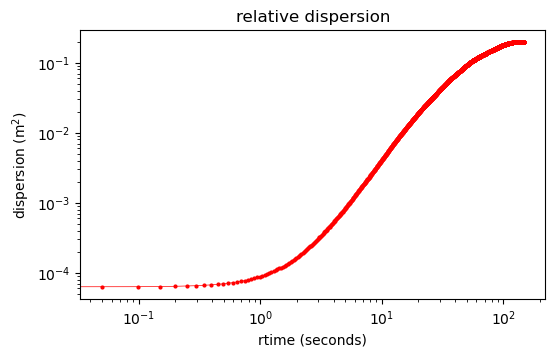

In [8]:
xpos = rd.get_variable(origin_pairs, 'x')
ypos = rd.get_variable(origin_pairs, 'y')

xpos1 = xpos.isel(particle=0)
xpos2 = xpos.isel(particle=1)
ypos1 = ypos.isel(particle=0)
ypos2 = ypos.isel(particle=1)

# get relative dispersion
r2  = (xpos1-xpos2)**2+(ypos1-ypos2)** 2.0 # this is single realizations
r2m = r2.mean('pair') # this is ensemble averaged dispersion

r2m.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5)
plt.title('relative dispersion')
plt.xlabel('rtime (seconds)')
_ = plt.ylabel('dispersion (m$^2$)')

There are N original pairs and thus N realizations of relative dispersion.  One need to bootstrap over these pairs to see the robustness of the statistics.  Bootstrapping is done many times by re-sampling these N pairs with replacement (allowing re-sample the same pair).  Here we bootstrap 1000 times to obtain the upper and lower bounds of relative dispersion.

In [ ]:
from xdispersion.utils import bootstrap

def func(r2):
    # define a function to tell bootstrap how to get a mean sample
    return r2.mean('pair')

lower, upper = bootstrap(func, [r2], {}, ensemble=1000, CI=0.95)

Now plot the dispersion ith confidence interval

In [ ]:
import matplotlib.pyplot as plt

r2m.plot.line(xscale='log', yscale='log', figsize=(9,5), marker='o', color='r', markersize=2, lw=0.5, zorder=1)
plt.fill_between(r2m.rtime, lower, upper, alpha=0.2, color='r', zorder=-5)
plt.title('relative dispersion')
plt.xlabel('rtime (s)')
plt.ylabel('dispersion (m$^2$)')

## Comparison with analytical predictions

Analytical predictions for relative dispersion can be summarized into a table:

| wavenumber spectra | regimes | free parameters| predictions of relative dispersion |
| :----------------- | :-----: | :------------: | :--------------------------------: |
| $K^{-3}$ or steeper | nonlocal (Lundgren) | $T_L$ | $r_0^2 \exp\left(\frac{8t}{T_L}\right)$ |
| $K^{-2}$ | local (GM internal wave) | $\lambda$ | $3.28125\lambda^4 t^4$ (asymptotic) |
| $K^{-5/3}$ | local (Richardson) | $\beta$ | $5.2675\beta^3 t^3$ (asymptotic) |
| decorrelated | diffusive (Rayleigh) | $\kappa_2$ | $r_0^2 + 4\kappa_2 t$ |

Now we **guess** that the dispersion follows the Richardson's $t^3$ behavior.  We them calculate this behavior by adjusting some free parameters.

In [ ]:
from xdispersion import ana_r2

# free parameters beta, k2, and r0 for different regimes
richardson = ana_r2(r2, params={'beta':0.04, 'r0':0.05},
                    regime='richardson-a')  # asymptotic Richardson prediciton (t^3)
diffusive  = ana_r2(r2, params={'k2':0.003  , 'r0':0.05},
                    regime='diffusive'   )  # diffusive or Rayleigh regime (t^1)

# one may also simply do this by: richardson = r2.rtime ** 3.0
# but we need to scale this to fit the curve, similar to adjusting the free parameter 'beta'
# This is only the asymptotic regime.  With 'r2_ana', we could get the full Richardson prediction

In [ ]:

richardson = richardson.sel(rtime=slice(5, 10)) # select 0-30 days
diffusive  =  diffusive.sel(rtime=slice(0.1, 10)) # select 20-100 days

r2m.plot.line(xscale='log', yscale='log', figsize=(6,4), marker='o', color='r', markersize=2, lw=0.5, zorder=1)
plt.plot(richardson.rtime, richardson, color='b', lw=1)
plt.plot(diffusive.rtime, diffusive, color='g', lw=1)
plt.fill_between(r2m.rtime, lower, upper, alpha=0.2, color='r', zorder=-5)
#plt.xlim([1e-1, 1e2])
#plt.ylim([1e-2, 3e5])
#plt.text(1e0, 1e1, '$r^2\\sim t^3$', size=12)
#plt.text(1e1, 5e4, '$r^2\\sim t^1$', size=12)
plt.title('relative dispersion')
plt.xlabel('rtime (s)')
plt.ylabel('dispersion (m$^2$)')

## Calculate separation based measures

In [ ]:
from xdispersion import gen_rbins, rel_disp, rel_diff, kurtosis, cumul_inv_sep_time

alpha = 1.2
rbins = gen_rbins(0.01, 0.5, alpha)

# get all building blocks for the four measures
rx, ry, rxy, r, rpb = rd.separation_measures(origin_pairs)

r2   = rel_disp(r, order=2, mean_at='const-t') #order=2 so 2nd moment of separation
K2   = rel_diff(r, mean_at='const-t') #Relative diffusivity
Ku, lower, upper    = kurtosis(r, mean_at='const-t',ensemble=100) #kurtosis=4th moment
# Cumulative Inverse Separation Time
CIST = cumul_inv_sep_time(r, rbins=rbins, lower=0.1, upper=0.9,
                          maskout=[1e-8, 5e3], mean_at='const-r')

#Values determined from fits:
beta=1e-2
kappal=6.5e-4
T=10

/home/dgsl1/miniforge3/envs/xdispersion/lib/python3.13/site-packages/xhistogram/core.py:462: RuntimeWarning: invalid value encountered in divide
  h = bin_counts / bin_areas / reshape(bin_count_sums, bin_count_sums_shape)


### Plot dispersion

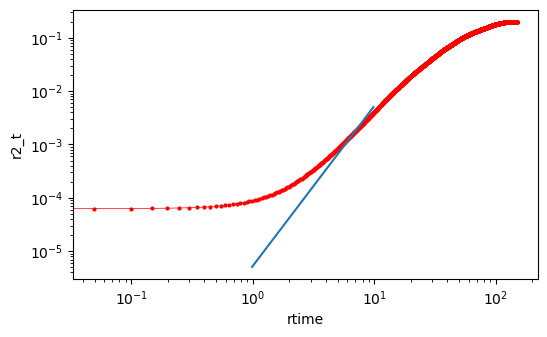

In [27]:
r2.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5)
plt.plot(r2.rtime[20:200],5.2675*(beta)**3*r2.rtime[20:200]**3)

### Plot relative diffusivity (time derivative of dispersion)

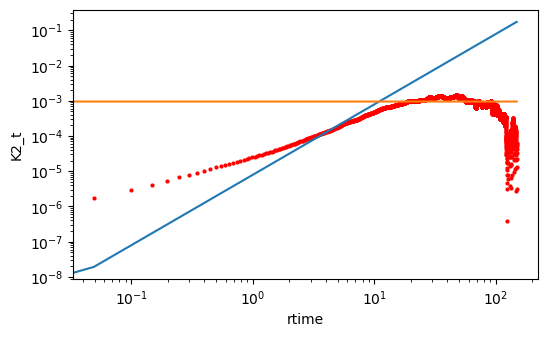

In [28]:
K2.plot(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0)
plt.plot(K2.rtime,(3/2)*5.2575*(beta)**3*K2.rtime**(2))
plt.plot(K2.rtime,K2.rtime*0+0.00095)



Now plot it as a function of rms separation instead of function of time.

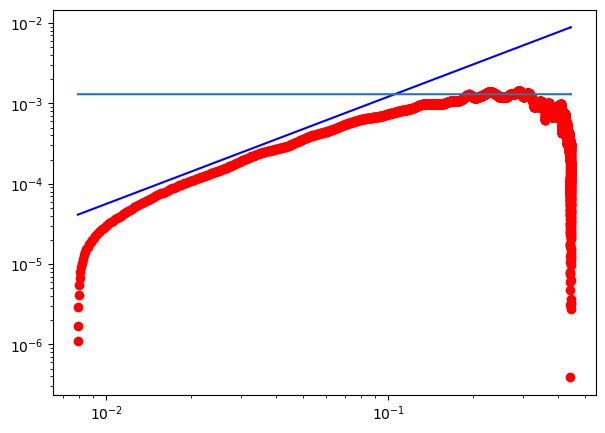

In [29]:
rtmp = np.sqrt(r2)

plt.figure(figsize=(7, 5))
plt.scatter(rtmp.values,K2.values,color='red')
plt.plot(rtmp,2.61*beta*rtmp**(4/3),color='blue')
plt.plot(rtmp,rtmp*0+2*kappal)
plt.xscale('log')
plt.yscale('log')

### Compute pFSLE

We can also calculate the pFSLE from the relative diffusivity (see eqaution 2.8 in Lacasce and Meunier JFM 2021)

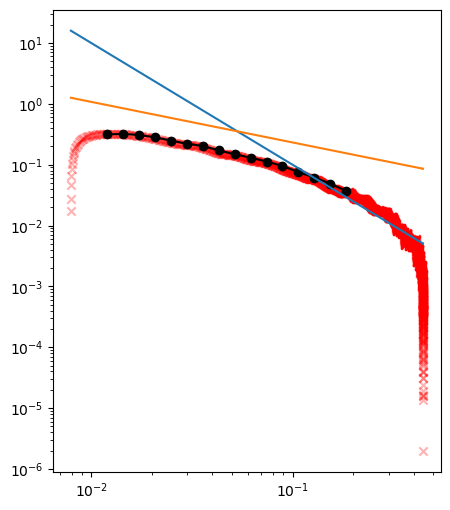

In [30]:
pFSLE=K2.values/rtmp.values**2 #this has indeed dimension of inverse time

# Digitize rtmp values into bins
bin_indices = np.digitize(rtmp.values, rbins)
# Prepare arrays to store binned statistics
# Prepare array to store binned mean
pFSLE_binned_mean = np.full(len(rbins[1:]), np.nan)

# Compute mean pFSLE in each bin
for i in range(1, len(rbins)):
    mask = bin_indices == i
    if np.any(mask):
        pFSLE_binned_mean[i - 1] = np.nanmean(pFSLE[mask])

plt.figure(figsize=(5, 6))
#plt.scatter(rtmp.values,pFSLE,marker='x',color='red')
plt.scatter(rtmp.values, pFSLE, marker='x', color='red', alpha=0.3, label='Raw data')
plt.plot(rbins[1:], pFSLE_binned_mean, 'o-', color='black', label='Binned mean')
plt.plot(rtmp,0.001*rtmp**(-2))
plt.plot(rtmp,0.05*rtmp**(-2/3))
plt.xscale('log')
plt.yscale('log')

### Plot Kurtosis

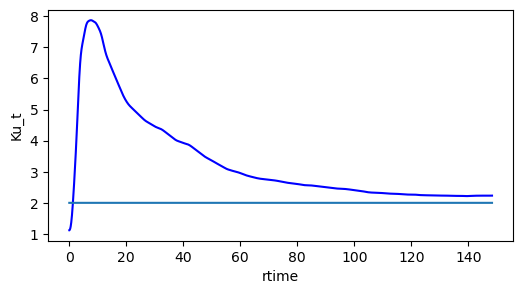

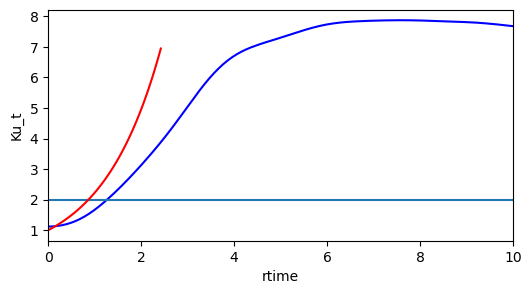

In [31]:
Ku.plot(xscale='linear', figsize=(6, 3), c='b')
#plt.fill_between(Ku.rtime, lower, upper, alpha=0.2, color='b')
plt.plot(Ku.rtime,Ku.rtime*0+2)

Ku.plot(xscale='linear', figsize=(6, 3), c='b')
#plt.fill_between(Ku.rtime, lower, upper, alpha=0.2, color='b')
plt.plot(Ku.rtime,Ku.rtime*0+2)
plt.xlim(0,10)
plt.plot(Ku.rtime.values[:50], np.exp(8 * Ku.rtime.values[:50]/T), 'r-', label='exp(8*rtime)')

## Compute the PDF and CDF and plot them

/home/dgsl1/miniforge3/envs/xdispersion/lib/python3.13/site-packages/xhistogram/core.py:462: RuntimeWarning: invalid value encountered in divide
  h = bin_counts / bin_areas / reshape(bin_count_sums, bin_count_sums_shape)


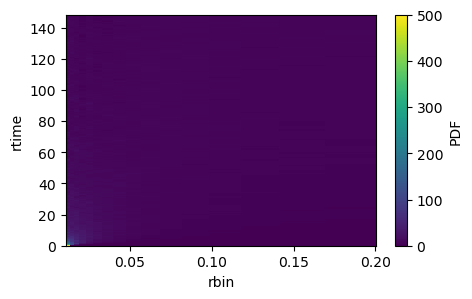

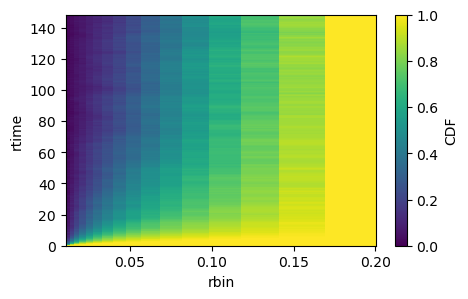

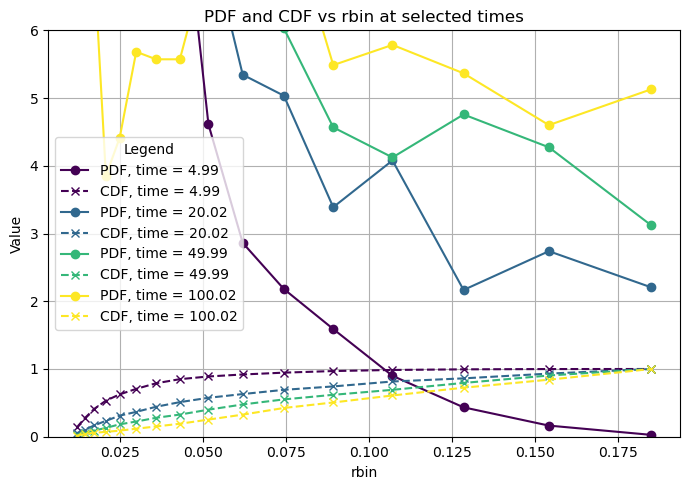

In [32]:
from xdispersion import * 

fig, axes = plt.subplots(figsize=(5, 3))
PDF=prob_dens_func(r,rbins)
PDF.plot()

fig, axes = plt.subplots(figsize=(5, 3))
CDF = cumul_dens_func(PDF,rbins)
CDF.plot()

import matplotlib.pyplot as plt

# Choose a specific time index or value
times = [5, 20.0, 50.0,100]  # can be any number of time values

# Choose a colormap and get distinct colors
colors = cm.viridis(np.linspace(0, 1, len(times)))

plt.figure(figsize=(7, 5))

for i, t in enumerate(times):
    # Select slices
    pdf_slice = PDF.sel(rtime=t, method='nearest')
    cdf_slice = CDF.sel(rtime=t, method='nearest')
    
    # Get actual time (in case nearest doesn't match exactly)
    time_val = pdf_slice.rtime.values

    # Plot PDF (solid line)
    plt.plot(
        PDF.rbin, pdf_slice,
        color=colors[i],
        linestyle='-',
        marker='o',
        label=f'PDF, time = {time_val:.2f}'
    )
    
    # Plot CDF (dashed line)
    plt.plot(
        CDF.rbin, cdf_slice,
        color=colors[i],
        linestyle='--',
        marker='x',
        label=f'CDF, time = {time_val:.2f}'
    )

plt.xlabel('rbin')
plt.ylabel('Value')
plt.ylim(0, 6)
plt.title('PDF and CDF vs rbin at selected times')
plt.grid(True)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()

In [33]:
print(rbins.values[15])

0.1540702157458636


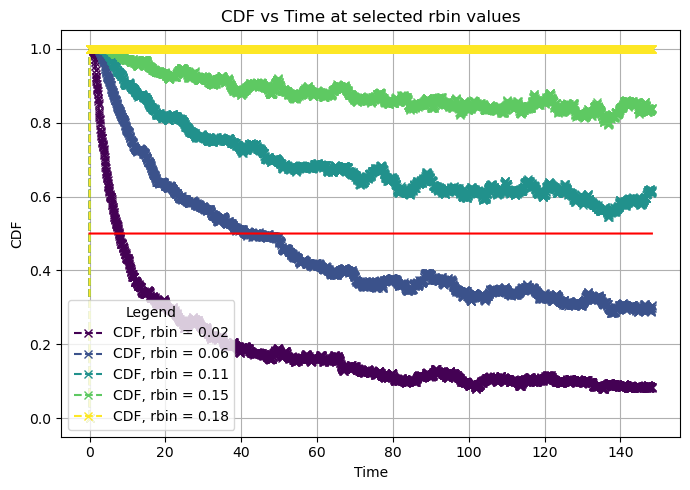

In [39]:
# Select fixed rbin values instead of time
rbins_to_plot = [rbins.values[5],rbins.values[10], rbins.values[13], rbins.values[15], rbins.values[16]]  # example rbin values

# Choose a colormap and get distinct colors
colors = cm.viridis(np.linspace(0, 1, len(rbins_to_plot)))

plt.figure(figsize=(7, 5))

for i, rb in enumerate(rbins_to_plot):
    # Select slices
    cdf_slice = CDF.sel(rbin=rb, method='nearest')
    
    # Get actual rbin (in case nearest doesn't match exactly)
    rbin_val = cdf_slice.rbin.values

    # Plot CDF vs time at this rbin
    plt.plot(
        CDF.rtime, cdf_slice,
        color=colors[i],
        linestyle='--',
        marker='x',
        label=f'CDF, rbin = {rbin_val:.2f}'
    )

plt.plot(CDF.rtime,CDF.rtime*0+0.5,color='red')
plt.xlabel('Time')
plt.ylabel('CDF')
plt.title('CDF vs Time at selected rbin values')
plt.grid(True)
plt.legend(title="Legend")
plt.tight_layout()
plt.show()


## Plot the fit of the CDF to find the values for which c=0.5

In [36]:
print(rbins.values.min())

0.01


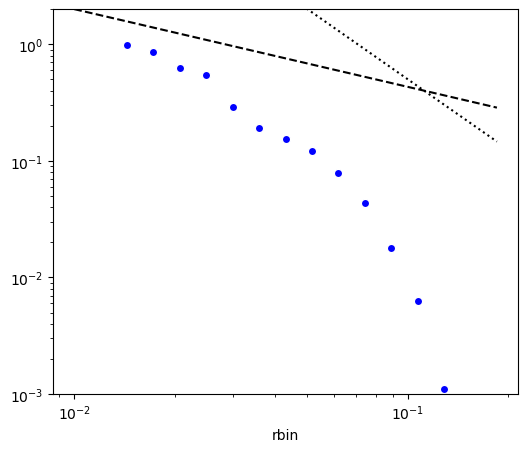

In [37]:
from xdispersion import semilog_fit

lower=0.1
upper=0.9
CDFrng = CDF.where(np.logical_and(CDF>lower, CDF<upper))

# Use a semilog fit to find where CDF crosses value 0.5         
slope, inter, rms = xr.apply_ufunc(semilog_fit, CDFrng['rtime'], CDFrng,
                                               dask='allowed',
                                               input_core_dims=[['rtime'], ['rtime']],
                                               output_core_dims=[[], [], []],
                                               vectorize=True)
            
fitted = np.exp((0.5 - inter) / slope)
diff = fitted.diff('rbin')
CIST  = 1.0 / diff

CIST.plot.scatter(yscale='log',xscale='log', figsize=(6, 5), c='b')
plt.ylim(10**(-3), 2)

# Reference line with slope -2/3
y_ref1 = rbins.values**(-2/3)
# Normalize so it appears in the vertical range of the plot
y_ref1 *= 2 / y_ref1[0]  # Scale to start around y=0.5

# Reference line with slope -2
y_ref2 = rbins.values**(-2)
y_ref2 *= 50 / y_ref2[0]  # Scale to start around y=0.01

plt.plot(rbins.values, y_ref1, 'k--', label='slope = -2/3')
plt.plot(rbins.values, y_ref2, 'k:', label='slope = -2')


/tmp/ipykernel_62816/4179600240.py:34: RuntimeWarning: divide by zero encountered in log
  log_rtime = np.log(rtime_vals)


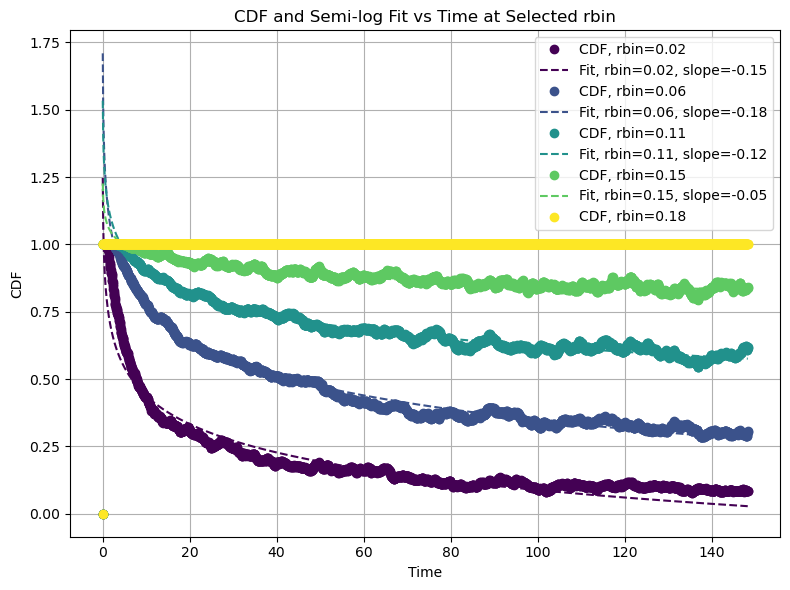

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import cm



# Plot original CDF curves and fitted lines
plt.figure(figsize=(8, 6))

for i, rb in enumerate(rbins_to_plot):
    # Extract CDF data at this rbin
    cdf_line = CDF.sel(rbin=rb, method='nearest')
    rtime_vals = cdf_line['rtime'].values
    cdf_vals = cdf_line.values
    rb_val = cdf_line.rbin.values

    # Plot raw CDF
    plt.plot(
        rtime_vals,
        cdf_vals,
        marker='o',
        linestyle='',
        color=colors[i],
        label=f'CDF, rbin={rb_val:.2f}'
    )

    # Get slope and intercept for this rbin
    m = slope.sel(rbin=rb, method='nearest').values
    b = inter.sel(rbin=rb, method='nearest').values

    # Avoid NaN fits
    if np.isfinite(m) and np.isfinite(b):
        log_rtime = np.log(rtime_vals)
        fit_vals = m * log_rtime + b

        plt.plot(
            rtime_vals,
            fit_vals,
            linestyle='--',
            color=colors[i],
            label=f'Fit, rbin={rb_val:.2f}, slope={m:.2f}'
        )

plt.xlabel('Time')
plt.ylabel('CDF')
plt.title('CDF and Semi-log Fit vs Time at Selected rbin')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Compare semilog fit with exponential fit

### Define the exponential fit function

In [41]:

from typing import Tuple
from scipy.optimize import curve_fit
import numpy as np

def exp_decay_offset_fit(t: np.array, y: np.array) -> Tuple[float, float, float, float, float]:
    """Fit y = A * exp(-(t - t0) / tau) + C with delay and offset."""
    idx = ~np.isnan(y)
    t_fit = t[idx]
    y_fit = y[idx]

    if len(y_fit) < 4:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    try:
        def model(t, A, tau, t0, C):
            t_shifted = t - t0
            return np.where(t_shifted >= 0, A * np.exp(-t_shifted / tau) + C, A + C)

        # Initial guesses: [A, tau, t0, C]
        A0 = y_fit.max() - y_fit.min()
        tau0 = (t_fit.max() - t_fit.min()) / 3
        t0_0 = t_fit.min()
        C0 = y_fit.min()

        popt, _ = curve_fit(model, t_fit, y_fit, p0=[A0, tau0, t0_0, C0], maxfev=10000)
        A, tau, t0, C = popt

        y_pred = model(t_fit, A, tau, t0, C)
        rmse = np.sqrt(np.mean((y_pred - y_fit) ** 2))
        return A, tau, t0, C, rmse

    except:
        return np.nan, np.nan, np.nan, np.nan, np.nan



### Apply the exponential fit and plot

/tmp/ipykernel_62816/288944454.py:27: RuntimeWarning: divide by zero encountered in log
  log_rtime = np.log(rtime_vals)


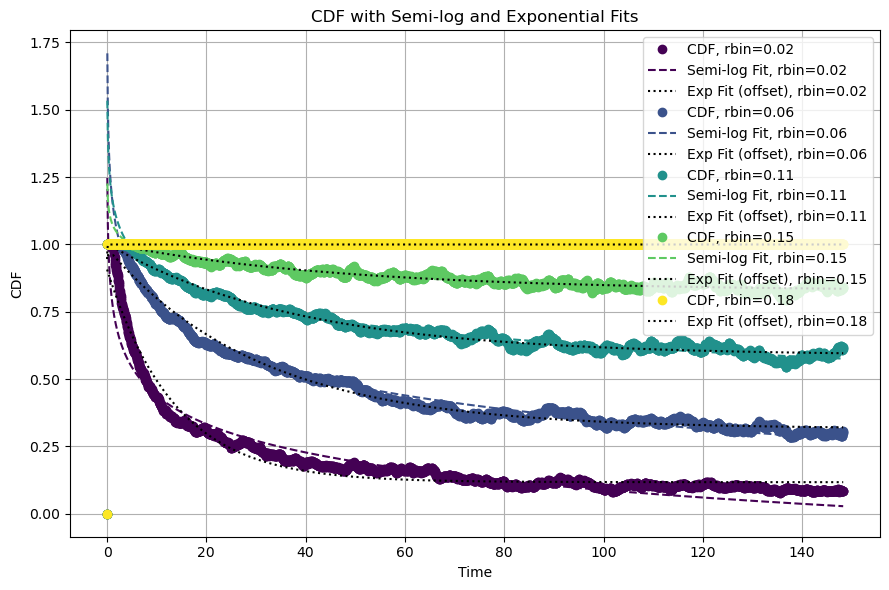

In [42]:
A_exp, tau_exp, t0_exp, C_exp, rmse_exp = xr.apply_ufunc(
    exp_decay_offset_fit,
    CDF['rtime'],
    CDF,
    dask='allowed',
    input_core_dims=[['rtime'], ['rtime']],
    output_core_dims=[[], [], [], [], []],
    vectorize=True
)


plt.figure(figsize=(9, 6))

for i, rb in enumerate(rbins_to_plot):
    # Raw CDF
    cdf_line = CDF.sel(rbin=rb, method='nearest')
    rtime_vals = cdf_line['rtime'].values
    cdf_vals = cdf_line.values
    rb_val = cdf_line.rbin.values

    plt.plot(rtime_vals, cdf_vals, 'o', color=colors[i], label=f'CDF, rbin={rb_val:.2f}')

    # Semi-log fit
    m = slope.sel(rbin=rb, method='nearest').values
    b = inter.sel(rbin=rb, method='nearest').values
    if np.isfinite(m) and np.isfinite(b):
        log_rtime = np.log(rtime_vals)
        semi_log_fit = m * log_rtime + b
        plt.plot(rtime_vals, semi_log_fit, '--', color=colors[i], label=f'Semi-log Fit, rbin={rb_val:.2f}')

    # Exponential fit
    A = A_exp.sel(rbin=rb, method='nearest').values
    tau = tau_exp.sel(rbin=rb, method='nearest').values
    t0 = t0_exp.sel(rbin=rb, method='nearest').values
    C = C_exp.sel(rbin=rb, method='nearest').values

    if np.all(np.isfinite([A, tau, t0, C])):
        t_vals = rtime_vals
        t_shifted = t_vals - t0
        exp_fit = np.where(t_shifted >= 0, A * np.exp(-t_shifted / tau) + C, A + C)
    
        #plt.plot(t_vals, exp_fit, ':', color=colors[i], label=f'Exp Fit (offset), rbin={rb_val:.2f}')
        plt.plot(t_vals, exp_fit, ':', color='black', label=f'Exp Fit (offset), rbin={rb_val:.2f}')


plt.xlabel('Time')
plt.ylabel('CDF')
plt.title('CDF with Semi-log and Exponential Fits')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/home/dgsl1/miniforge3/envs/xdispersion/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


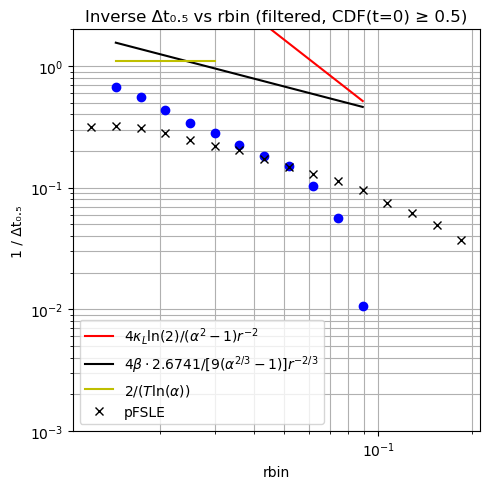

In [43]:
# 1. Compute t₀.₅ (time where CDF = 0.5)
valid_mask = np.logical_and(
    A_exp > 0,
    np.logical_and(tau_exp > 0, (0.5 - C_exp) / A_exp > 0)
)

t_half_exp = xr.where(
    valid_mask,
    t0_exp - tau_exp * np.log((0.5 - C_exp) / A_exp),
    np.nan
)


# 2. Use a mask to exclude rbins for which CDF at t = 0 is already smaller than 0.5
cdf_at_t0 = CDF.sel(rtime=0, method='nearest')
valid_rbins = cdf_at_t0 >= 0 #0.5

# 3. Apply the mask to t_half_exp
t_half_masked = t_half_exp.where(valid_rbins)

# 4. Drop NaNs to make diff() work cleanly
t_half_clean = t_half_masked.dropna(dim='rbin')

# 5. Compute Δt_half and its inverse
dt_half = t_half_clean.diff('rbin')
inv_dt_half = 1.0 / dt_half

# 6. rbin values corresponding to upper bins in diff
rbin_upper = t_half_clean['rbin'][1:]

# 7. Plots



plt.figure(figsize=(5, 5))
plt.plot(rbin_upper, inv_dt_half, 'bo')
plt.plot(rbin_upper, 4*kappal*np.log(2)/(alpha**2-1)*rbin_upper**(-2), 'r-', label=r'$4\kappa_L \ln(2)/( \alpha^2 - 1)  r^{-2}$')
plt.plot(rbin_upper, 4*beta*2.6741/(9*(alpha**(2/3)-1))*rbin_upper**(-2/3), 'k-', label=r'$4\beta \cdot 2.6741 / [9 (\alpha^{2/3} - 1)]  r^{-2/3}$')
plt.plot(rbin_upper[:5], rbin_upper[:5]*0+2/T/np.log(alpha), 'y-',label=r'$2 / (T \ln(\alpha))$')
plt.plot(rbins[1:], pFSLE_binned_mean, 'x', color='black', label='pFSLE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rbin')
plt.ylabel('1 / Δt₀.₅')
plt.ylim(10**(-3), 2)
plt.title('Inverse Δt₀.₅ vs rbin (filtered, CDF(t=0) ≥ 0.5)')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()



In [44]:
print(CDF.rtime.values.max())

148.27819878214922


/tmp/ipykernel_62816/3491836987.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(0,10**4)


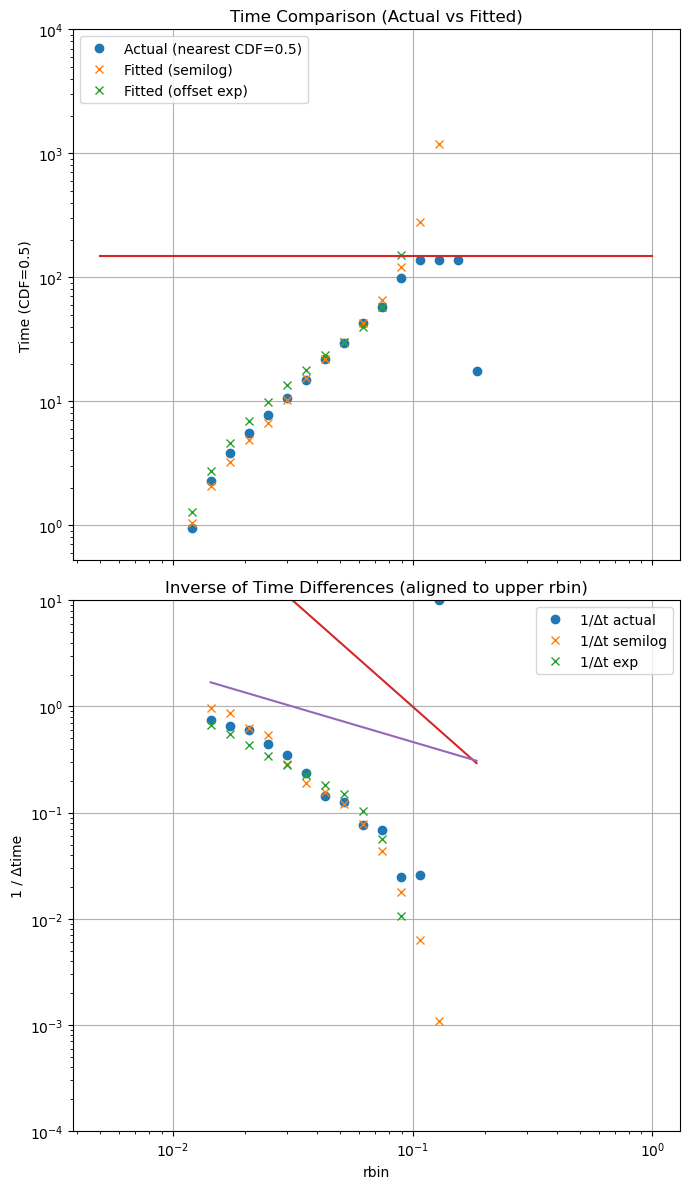

In [45]:
# Find the index of the value in the CDF nearest to 0.5 (to compare with the fit)
idx_nearest = abs(CDF - 0.5).argmin(dim='rtime')
actual_time = CDF['rtime'].isel(rtime=idx_nearest)
tmax = CDF.rtime.values.max()

# Compute inverse of time differences (Δt⁻¹)
inv_diff_actual = 1.0 / actual_time.diff('rbin')
inv_diff_fitted = 1.0 / fitted.diff('rbin')
inv_diff_exp = 1.0 / t_half_exp.diff('rbin')
# Use the *upper* bin of each pair for x-axis
rbin_upper = CDF.rbin.isel(rbin=slice(1, None))

fig, axs = plt.subplots(2, 1, figsize=(7, 12), sharex=True)

# --- Subplot 1: Time where CDF = 0.5 ---
axs[0].plot(CDF.rbin, actual_time, 'o', label='Actual (nearest CDF=0.5)')
axs[0].plot(CDF.rbin, fitted, 'x', label='Fitted (semilog)')
axs[0].plot(CDF.rbin, t_half_exp, 'x', label='Fitted (offset exp)')
axs[0].plot([0.005,1],[tmax,tmax])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel('Time (CDF=0.5)')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Time Comparison (Actual vs Fitted)')
axs[0].set_ylim(0,10**4)

# --- Subplot 2: Inverse Time Differences ---
axs[1].plot(rbin_upper, inv_diff_actual, 'o', label='1/Δt actual')
axs[1].plot(rbin_upper, inv_diff_fitted, 'x', label='1/Δt semilog')
axs[1].plot(rbin_upper, inv_diff_exp, 'x', label='1/Δt exp')
axs[1].plot(rbin_upper, 0.01*rbin_upper**(-2), '-')
axs[1].plot(rbin_upper, 0.1*rbin_upper**(-2/3), '-')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('rbin')
axs[1].set_ylabel('1 / Δtime')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Inverse of Time Differences (aligned to upper rbin)')
axs[1].set_ylim(10**(-4),10)

plt.tight_layout()
plt.show()

In [ ]:
print(rbins.values)

In [ ]:
#alpha = 1.2
#rbins2 = gen_rbins(0.001, 0.2, alpha)

CIST = cumul_inv_sep_time(r, rbins=rbins, lower=0.05, upper=0.95,
                          maskout=[1e-8, 5e3], mean_at='const-r')

print(CIST)

CIST.plot.scatter(yscale='log',xscale='log', figsize=(6, 4), c='b')
plt.plot(rbins.values, y_ref1, 'k--', label='slope = -2/3')
plt.plot(rbins.values, y_ref2, 'k:', label='slope = -2')
